In [ ]:
'''
【项目07】  城市餐饮店铺选址分析

1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标西，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分


'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Loading BokehJS ...

In [ ]:
'''
1、从三个维度“口味”、“人均消费”、“性价比”对不同菜系进行比较，并筛选出可开店铺的餐饮类型
要求：
① 计算出三个维度的指标得分
② 评价方法：
   口味 → 得分越高越好
   性价比 → 得分越高越好
   人均消费 → 价格适中即可
③ 制作散点图，x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”
   绘制柱状图，分别显示“口味得分”、“性价比得分”
   * 建议用bokeh做图
提示：
① 数据清洗，清除空值、为0的数据
② 口味指标计算方法 → 口味评分字段，按照餐饮类别分组算均值，再做标准化处理
③ 人均消费指标计算方法 → 人均消费字段，按照餐饮类别分组算均值，再做标准化处理
④ 性价比指标计算方法 → 性价比 = （口味 + 环境 + 服务）/人均消费，按照餐饮类别分组算均值，再做标准化处理
⑤ 数据计算之前，检查一下数据分布，去除异常值（以外限为标准）
   * 这里排除了高端奢侈餐饮的数据干扰
⑥ 注意，这里先分别计算三个指标，再合并数据（merge）作图，目的是指标之间的噪音数据不相互影响

'''

In [2]:
# 查看数据

import os
os.chdir(r'C:\Users\Administrator\Python数据\网易数据分析\1项目资料\项目07城市餐饮店铺选址分析')
# 创建工作路径

df1 = pd.read_excel('上海餐饮数据.xlsx',sheet_name=0,header=0)
df1_length = len(df1)
# df1_columns = df1.columns.tolist() # 提取列名
print('数据量为%i条' % len(df1),'\n')
print(df1.head())

数据量为96398条 

   类别    行政区  点评数   口味   环境   服务  人均消费   城市         Lng        Lat
0  烧烤   浦东新区  176  8.0  8.6  7.9   124  上海市  121.967860  30.884477
1  美食    闵行区    2  6.1  6.5  6.3     0  上海市  121.967781  30.883818
2  粤菜   浦东新区  141  6.7  7.2  6.6   141  上海市  121.933142  30.893224
3  海鲜   浦东新区   76  7.2  7.2  7.3   148  上海市  121.926062  30.899868
4  烧烤   浦东新区  600  7.2  7.6  7.0   143  上海市  121.925877  30.901100


,口味,口味_norm,人均消费,人均消费_norm,性价比,性价比_norm
类别,,,,,,
素菜,8.021705,1.000000,71.251969,0.364955,0.497415,0.371044
南菜,7.984874,0.948128,91.411765,0.527529,0.325731,0.182992
本菜,7.959824,0.912848,111.316243,0.688044,0.287742,0.141381
火锅,7.949428,0.898206,98.524051,0.584884,0.282454,0.135589
亚菜,7.889937,0.814421,94.426724,0.551842,0.310835,0.166675


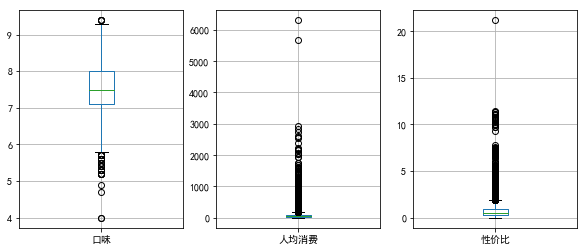

In [3]:
# 口味、客单价、性价比指标计算

data1 = df1[['类别','口味','环境','服务','人均消费']]
data1.dropna(inplace = True)
# data1 = data1[(data1['口味']>0)&(data1['人均消费']>0)]
data1 = data1[(data1['口味']>0)&(data1['环境']>0)&(data1['服务']>0)&(data1['人均消费']>0)]
# 筛选数据，清除空值、为0的数据

data1['性价比'] = (data1['口味'] + data1['环境'] + data1['服务']) / data1['人均消费']
# 计算性价比指数，添加'性价比'列数据

fig,axes = plt.subplots(1,3,figsize = (10,4))
data1.boxplot(column=['口味'],ax = axes[0])
data1.boxplot(column=['人均消费'],ax = axes[1])
data1.boxplot(column=['性价比'],ax = axes[2]) 
# 用箱形图，查看异常值

def f1(data,col):
    q1 = data[col].quantile(q = 0.25)
    q3 = data[col].quantile(q = 0.75) 
    iqr = q3-q1
    t1 = q1 - 3 * iqr
    t2 = q3 + 3 * iqr
    return data[(data[col] > t1)&(data[col]<t2)][['类别',col]]
# 创建函数 → 删除异常值

data_kw = f1(data1,'口味')
data_rj = f1(data1,'人均消费')
data_xjb = f1(data1,'性价比')
# 数据异常值处理,分成三个data

def f2(data,col):
    col_name = col + '_norm'
    data_gp = data.groupby('类别').mean() # 按菜品类别的分组，'.mean()'得到的是每种菜品的平均值
#     print(data_gp.index[:100])
    data_gp[col_name] = (data_gp[col] - data_gp[col].min())/(data_gp[col].max()-data_gp[col].min())
    data_gp.sort_values(by = col_name, inplace = True, ascending=False)
    return data_gp
# 创建函数 → 先通过.mean()均值，再标准化指标并排序,即是均值的标准化

data_kw_score = f2(data_kw,'口味')
data_rj_score = f2(data_rj,'人均消费')
data_xjb_score = f2(data_xjb,'性价比')
# 指标标准化得分

data_final_q1 = pd.merge(data_kw_score,data_rj_score,left_index=True,right_index=True)    # 合并口味、人均消费指标得分
data_final_q1 = pd.merge(data_final_q1,data_xjb_score,left_index=True,right_index=True)       # 合并性价比指标得分
# 合并数据

data_final_q1.head()

In [4]:
# 制作散点图、柱状图
# x轴为“人均消费”，y轴为“性价比得分”，点的大小为“口味得分”

from bokeh.models import HoverTool # 悬停工具
from bokeh.palettes import brewer # 
from bokeh.models.annotations import BoxAnnotation # 注释，用于显示price_mid
from bokeh.layouts import gridplot
# 导入模块

data_final_q1['size'] = data_final_q1['口味_norm'] * 40  # 添加size字段,显著华显示'口味_norm'
data_final_q1.index.name = 'type'
data_final_q1.columns = ['kw','kw_norm','price','price_norm','xjb','xjb_norm','size']
# 将中文改为英文
# 添加颜色参数
print(data_final_q1.head())

source = ColumnDataSource(data_final_q1)
# 创建ColumnDataSource数据

hover = HoverTool(tooltips=[("餐饮类型", "@type"),
                            ("人均消费", "@price"),
                            ("性价比得分", "@xjb_norm"),
                            ("口味得分", "@kw_norm")
                           ])  # 设置标签显示内容
result = figure(plot_width=800, plot_height=250,
                title="餐饮类型得分情况" ,
                x_axis_label = '人均消费', y_axis_label = '性价比得分', 
                tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair']) # tools即是组合图左上角的工具选项
# 构建绘图空间
result.circle(x = 'price',y = 'xjb_norm',source = source,
         line_color = 'black',line_dash = [6,4],fill_alpha = 0.6, # line_dash = [6,4] 点图圆圈线条虚线化，'6'是线段长度，'4'是缺口长度。
         size = 'size')                                           # size 就是 口味_norm * 40 ，fill_alpha 填充透明度
        
price_mid = BoxAnnotation(left=40,right=80, fill_alpha=0.3, fill_color='yellow')   
result.add_layout(price_mid)
# 设置人均消费中间价位区间

result.title.text_font_style = "bold"
result.ygrid.grid_line_dash = [6, 4] # 背景网格
result.xgrid.grid_line_dash = [6, 4] # 背景网格
# 散点图,title文字格式以及背景网格虚线的设置

# 绘制柱状图
data_type = data_final_q1.index.tolist()# 提取横坐标
print('---\ndata_type是\n---',data_type)

kw = figure(plot_width=800, plot_height=250, title='口味得分',x_range=list(data_final_q1.index),
           tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
kw.vbar(x='type', top='kw_norm', source=source,width=0.9, alpha = 0.8,color = 'red')

kw.ygrid.grid_line_dash = [6, 4] # 网格
kw.xgrid.grid_line_dash = [6, 4] # 网格
# 柱状图1

price = figure(plot_width=800, plot_height=250, title='人均消费得分',x_range=kw.x_range,# x_range = data_type效果相同
              tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
price.vbar(x='type', top='price_norm', source=source,width=0.9, alpha = 0.8,color = 'green')

price.ygrid.grid_line_dash = [6, 4] # 网格
price.xgrid.grid_line_dash = [6, 4] # 网格
# 柱状图2
    
p = gridplot([[result],[kw], [price]])
# 组合图表
show(p)

            kw   kw_norm       price  price_norm       xjb  xjb_norm  \
type                                                                   
素菜    8.021705  1.000000   71.251969    0.364955  0.497415  0.371044   
南菜    7.984874  0.948128   91.411765    0.527529  0.325731  0.182992   
本菜    7.959824  0.912848  111.316243    0.688044  0.287742  0.141381   
火锅    7.949428  0.898206   98.524051    0.584884  0.282454  0.135589   
亚菜    7.889937  0.814421   94.426724    0.551842  0.310835  0.166675   

           size  
type             
素菜    40.000000  
南菜    37.925100  
本菜    36.513934  
火锅    35.928242  
亚菜    32.576838  
---
data_type是
--- ['素菜', '南菜', '本菜', '火锅', '亚菜', '蟹宴', '西餐', '疆菜', '州菜', '料理', '海鲜', '粤菜', '啡厅', '湾菜', '烧烤', '西菜', '甜点', '龙虾', '面馆', '浙菜', '午茶', '川菜', '美食', '助餐', '快餐', '湘菜', '北菜', '常菜']


In [ ]:
'''
2、选择一个餐饮类型，在qgis中做将上海划分成格网空间，结合python辅助做空间指标评价，得到餐饮选址位置
* 课程这里以“素菜馆为例”
课程数据
① net_population.shp → 投影坐标系，上海1km²格网内的人口密度数据
② road.shp → 投影坐标系，上海道路数据
要求：
① 通过空间分析，分别计算每个格网内的几个指标：人口密度指标、道路密度指标、餐饮热度指标、同类竞品指标
② 评价方法：
   人口密度指标 → 得分越高越好
   道路密度指标 → 得分越高越好
   餐饮热度指标 → 得分越高越好
   同类竞品指标 → 得分越低越好
   综合指标 = 人口密度指标*0.4 + 餐饮热度指标*0.3 + 道路密度指标*0.2 +同类竞品指标*0.1
③ 最后得到较好选址的网格位置的中心坐标，以及所属区域
   * 可以用bokeh制作散点图
提示：
① 道路密度指标计算方法 → 网格内道路长度
② 餐饮热度指标计算方法 → 网格内餐饮poi计数
③ 同类竞品指标计算方法 → 网格内素菜馆poi计数
④ 餐饮poi数据记得投影
⑤ 可以以“net_population.shp”为网格基础数据，做空间统计
⑥ 在qgis做空间统计之后，网格数据导出点数据，投影成wgs84地理坐标系，导出excel数据，在python做指标标准化等
⑦ 在bokeh中做散点图时，注意添加一个size字段，通过最终评分来赋值
⑧ 在bokeh中做散点图时，可以给TOP10的点用颜色区分

'''

In [5]:

import os
os.chdir(r'E:\QGIS\项目实战practice\practice07\练习-南菜')
# 创建工作路径

# 加载数据

df2 = pd.read_excel('最终结果-南菜-经纬度.xlsx',sheet_name=0,header=0)
data2 = df2.fillna(0)
data2.columns = ['人口密度','道路长度','餐饮计数','南菜餐饮计数','lng','lat']

print(len(data2))
data2.head()

7222


,人口密度,道路长度,餐饮计数,南菜餐饮计数,lng,lat
0,0,0.000000,0,0,121.273114,30.685411
1,0,128.477758,0,0,121.262516,30.694291
2,0,1539.908057,0,0,121.272953,30.694430
3,0,1032.299541,0,0,121.283390,30.694569
4,0,1543.891782,0,0,121.293827,30.694706


In [6]:
# 指标统计

def f3(data,col):
    col_name = col + '_norm'
    data[col_name] = (data[col] - data[col].min())/(data[col].max()-data[col].min())
    return data

f3(data2,'人口密度')
# data2['rkmd_norm'] = (data2['人口密度']-data2['人口密度'].min())/(data2['人口密度'].max()-data2['人口密度'].min()) # 人口密度指标标准化

f3(data2,'餐饮计数')
# data2['cyrd_norm'] = (data2['餐饮计数']-data2['餐饮计数'].min())/(data2['餐饮计数'].max()-data2['餐饮计数'].min()) # 餐饮热度指标标准化

data2.rename(columns={ data2.columns[6]: "rkmd_norm", data2.columns[7]: "cyrd_norm"}, inplace=True) # 更改DataFrame的列名

data2['tljp_norm'] = (data2['南菜餐饮计数'].max()-data2['南菜餐饮计数'])/(data2['南菜餐饮计数'].max()-data2['南菜餐饮计数'].min()) 
# 同类竞品指标标准化，该项为负指标，当前值越接近最大值，所得的值就越小，即竞争越激烈，位置越不好。
data2['dlmd_norm'] = (data2['道路长度']-data2['道路长度'].min())/(data2['道路长度'].max()-data2['道路长度'].min()) # 道路密度指标标准化
# 指标标准化

data2['final_score'] = data2['rkmd_norm']*0.4 + data2['cyrd_norm']*0.3 + data2['tljp_norm']*0.1 + data2['dlmd_norm']*0.2 
#综合指标,题干有公式,是最后成图的指标，即是点的大小
data_final_q2 = data2.sort_values(by = 'final_score',ascending=False).reset_index() 
# .reset_index()，前面的sort打乱了index，需要新增index,该行命令主要是按照'final_score'排序。
data_final_q2[:10]
# 计算综合评分并查看TOP10的网格ID

,index,人口密度,道路长度,餐饮计数,南菜餐饮计数,lng,lat,rkmd_norm,cyrd_norm,tljp_norm,dlmd_norm,final_score
0,4372,35036,15483.180214,1244,2,121.473117,31.238244,0.820688,1.000000,0.6,0.528626,0.794000
1,4303,36929,9309.285084,1186,1,121.473262,31.229224,0.865030,0.953376,0.8,0.317837,0.775592
2,4301,36929,14010.454617,1049,1,121.452270,31.228973,0.865030,0.843248,0.8,0.478344,0.774655
3,4232,36929,12104.466337,972,0,121.452417,31.219953,0.865030,0.781350,1.0,0.413270,0.763071
4,4163,36929,14432.974864,895,3,121.463058,31.211060,0.865030,0.719453,0.4,0.492770,0.700402
5,4576,42691,11847.624492,403,0,121.483182,31.265427,1.000000,0.323955,1.0,0.404501,0.678087
6,4441,40623,14089.364209,362,0,121.483471,31.247388,0.951559,0.290997,1.0,0.481038,0.664130
7,4642,42691,11962.381378,504,2,121.472536,31.274322,1.000000,0.405145,0.6,0.408419,0.663227
8,4234,35036,14047.248280,803,3,121.473408,31.220204,0.820688,0.645498,0.4,0.479601,0.657845
9,4368,38393,11156.211334,466,0,121.431128,31.237738,0.899323,0.374598,1.0,0.380895,0.648288


In [12]:
# 制作空间散点图

data_final_q2['size'] = data_final_q2['final_score'] * 20
data_final_q2['color'] = 'green'
data_final_q2['color'].iloc[:20] = 'red' # 突出'final_score' * 20 高的值
# 添加size字段，添加color字段，在p.circle(,size = 'size',color = 'color')
print(data_final_q2.head())
print('\n',data_final_q2['color'].head())
source = ColumnDataSource(data_final_q2)
# 创建ColumnDataSource数据

hover = HoverTool(tooltips=[("经度", "@lng"),
                            ("纬度", "@lat"),
                            ("最终得分", "@final_score"),
                           ])  # 设置标签显示内容，十字线选中时显示的部分。

p = figure(plot_width=800, plot_height=800,
                title="空间散点图" , 
                tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair']) 

# 构建绘图空间

p.circle(x = 'lng',y = 'lat',source = source,
         line_color = 'black',fill_alpha = 0.5,
        size = 'size',color = 'color')

p.ygrid.grid_line_dash = [6, 4] # 背景网格Ｘ的虚线设置
p.xgrid.grid_line_dash = [6, 4] # 背景网格y的虚线设置
# 散点图
show(p)

   index   人口密度          道路长度  餐饮计数  南菜餐饮计数         lng        lat  rkmd_norm  \
0   4372  35036  15483.180214  1244       2  121.473117  31.238244   0.820688   
1   4303  36929   9309.285084  1186       1  121.473262  31.229224   0.865030   
2   4301  36929  14010.454617  1049       1  121.452270  31.228973   0.865030   
3   4232  36929  12104.466337   972       0  121.452417  31.219953   0.865030   
4   4163  36929  14432.974864   895       3  121.463058  31.211060   0.865030   

   cyrd_norm  tljp_norm  dlmd_norm  final_score       size color  
0   1.000000        0.6   0.528626     0.794000  15.880010   red  
1   0.953376        0.8   0.317837     0.775592  15.511847   red  
2   0.843248        0.8   0.478344     0.774655  15.493104   red  
3   0.781350        1.0   0.413270     0.763071  15.261424   red  
4   0.719453        0.4   0.492770     0.700402  14.008041   red  

 0    red
1    red
2    red
3    red
4    red
Name: color, dtype: object
